<a href="https://colab.research.google.com/github/chermont04/ML-DS-BootCamp/blob/main/notebooks/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/overview

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features 

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs
* There are around 10,000 images in training set
* There are around 10,000 images in the test set

In [1]:
#!unzip "drive/MyDrive/dog-vision-project/dog-breed-identification.zip" -d "drive/My Drive/dog-vision-project"

## Get our workspace ready

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "avaliable YES" 
      if tf.config.list_physical_devices("GPU") 
      else "not avaliable")

TF Hub version: 0.12.0
GPU avaliable YES


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of our data
labels_csv = pd.read_csv("drive/My Drive/dog-vision-project/labels.csv")
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


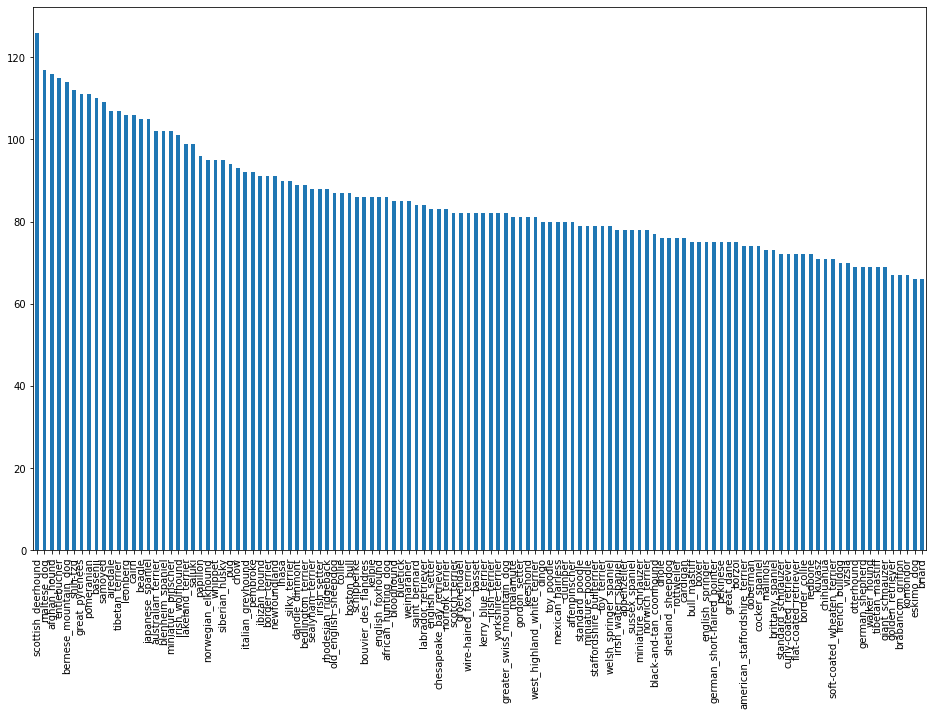

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize = (16, 10))

In [6]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

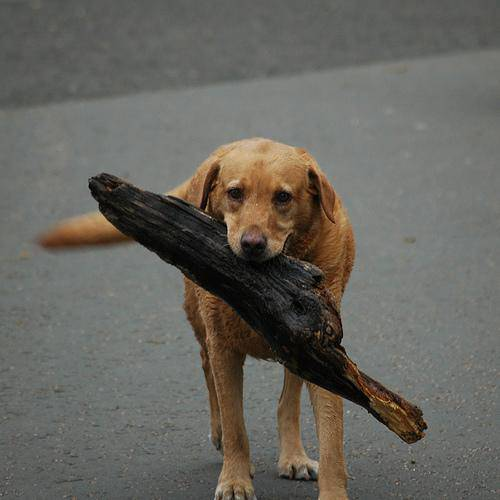

In [8]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/dog-vision-project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames

In [14]:
# Create pathnames from image Id's

filenames = ["drive/My Drive/dog-vision-project/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check first 10
filenames[:10]

['drive/My Drive/dog-vision-project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision-project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision-project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision-project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision-project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision-project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision-project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision-project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision-project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision-project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [16]:
# Check whether number of filenames matches number of actual image files
import os

if len(os.listdir("drive/MyDrive/dog-vision-project/train/")) == len(filenames):
  print("Filenames match actual amount of files.")
else:
  print("Filenames do not match actual amount of files.")

Filenames match actual amount of files.


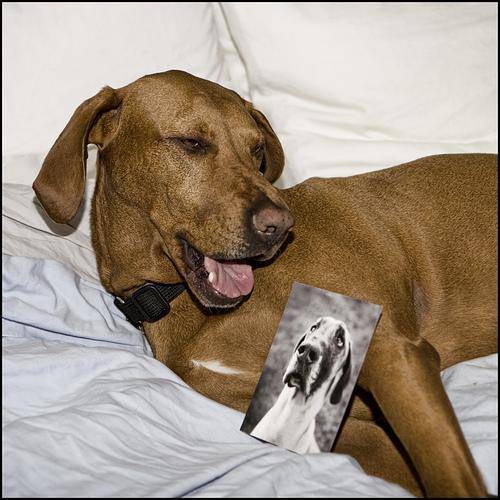

In [20]:
# One more check (data format)

Image(filenames[100])

In [22]:
labels_csv["breed"][100]

'rhodesian_ridgeback'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [23]:
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [24]:
len(labels)

10222

In [25]:
## Check if numbers of labels matcher the number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames")

Number of labels matches number of filenames


In [26]:
# Let's see the unique labels values

unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [27]:
# Turn a single label into an array of booleans

print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [31]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [32]:
len(boolean_labels)

10222

In [33]:
# Example: Turning boolean array into integers

print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
